In [28]:
from pylab import *
import numpy as np

def field_field_coherence(x,y,dt, trl_indx = None):

    if trl_indx is not None:
        x = x[trl_indx,:]
        y = y[trl_indx,:]
#    print(x.shape)
        
    T = x.shape[0]    
    N = x.shape[1] 
    
    #generating arrays
    SYY = np.zeros(int(N/2+1))                            
    SXX = np.zeros(int(N/2+1))                        
    SYX = np.zeros(int(N/2+1), dtype=complex)           

    #loop over trials
    for k in range(T):                                

        yf = rfft((y[k,:]-np.mean(y[k,:])) *hanning(N))   #rfft of y 
        nf = rfft((x[k,:]-np.mean(x[k,:])) *hanning(N))   #rfft of x
        SYY = SYY + ( real( yf*conj(yf) ) )/T       #this appends power spectra (for y) for this trial
        SXX = SXX + ( real( nf*conj(nf) ) )/T           # ""  for x
        SYX = SYX + ( yf*conj(nf)   )/T     # "" xy

    coh = abs(SYX) / np.sqrt(SYY) / np.sqrt(SXX)            
    f = rfftfreq(N, dt)
    
    return coh, f   

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
import copy
from scipy.ndimage import gaussian_filter1d


def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds.astype(float) > 1e-6    #finds the time points where std is not 0
    const_cols = stds.astype(float) <= 1e-6    #finds the time points where std is 0

    z = np.zeros_like(data[:, :])   #creates an array of zeros with the same shape as the data
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)  #in the columns where std is not 0, zscores the data
    z[:, const_cols] = np.mean(data[:, const_cols], axis=0)

 
    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

def sample_plots(l_al, r_al, a_al, l_ar, r_ar, a_ar, width, height):
    #plotting some traces
    fig, ax = plt.subplots(1, 2, figsize=(width, height))
    ax[0].plot(np.mean(l_al, axis = 0), label = 'left')
    ax[0].plot(np.mean(r_al, axis = 0), label = 'right')
    ax[0].plot(np.mean(a_al, axis = 0), label = 'attention')
    ax[0].set_title('attention left - mean across trials')
    ax[1].plot(np.mean(l_ar, axis = 0), label = 'left')
    ax[1].plot(np.mean(r_ar, axis = 0), label = 'right')
    ax[1].plot(np.mean(a_ar, axis = 0), label = 'attention')
    ax[1].set_title('attention right - mean across trials')
    plt.legend()
    plt.show()

    plt.plot(np.mean(l_al, axis = 0), label = 'left input - attleft')
    plt.plot(-1 * np.mean(l_ar, axis = 0), label = 'negative of left input - attright')
    plt.title('mean of left attleft and negative of left attright')
    plt.legend()
    plt.show()

    fign, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].plot(l_al[0, :], label = 'left input - attleft')
    ax[0].plot(r_al[0, :], label = 'right input - attleft')
    ax[0].plot(a_al[0, :], label = 'attention - attleft')
    ax[0].set_title('trial 0 attleft data')
    ax[1].plot(l_ar[0, :], label = 'left input - attright')
    ax[1].plot(r_ar[0, :], label = 'right input - attright')
    ax[1].plot(a_ar[0, :], label = 'attention - attright')
    ax[1].set_title('trial 0 attright data')
    plt.legend()
    plt.show()

In [ ]:
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
dt = 0.002
freq_ranges = [(0, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  # Actual frequency ranges
structure = {file_number: {band: {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for band in bands} for file_number in file_numbers} 

coherence_results = copy.deepcopy(structure)

def coherence_auc(file_number, data, condition, freq):
   for band, (fmin, fmax) in zip(bands, freq_ranges):
        band_idx = (freq >= fmin) & (freq < fmax)

        coherence_results[file_number][band][condition] = np.mean(data[band_idx])
              

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]

    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2
    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80

    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention

    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)


    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)


    #preprocess here now that we have traces of all of the relavant trials
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    #splitting left and right
    left_input_SP_attleft = left_input_SP[left_indices, 100:350]
    right_input_SP_attleft = right_input_SP[left_indices, 100:350]
    attention_SP_attleft = attention_SP[left_indices, 100:350]

    left_input_SP_attright = left_input_SP[right_indices, 100:350]
    right_input_SP_attright = right_input_SP[right_indices, 100:350]
    attention_SP_attright = attention_SP[right_indices, 100:350]      #as zscore is taken across trials for a given time, 
    #it should be the same preprocessing and then splicing time, as doing the reverse order
   

    #----- computing coherence ----------------
    left_attleft_coherence, freq_lal = field_field_coherence(
        left_input_SP_attleft, attention_SP_attleft, dt)
    right_attleft_coherence, freq_ral = field_field_coherence(
        right_input_SP_attleft, attention_SP_attleft, dt)
    left_attright_coherence, freq_lar = field_field_coherence(
        left_input_SP_attright, attention_SP_attright, dt)
    right_attright_coherence, freq_rar = field_field_coherence(
        right_input_SP_attright, attention_SP_attright, dt)

        
    coherence_auc(file_number, left_attleft_coherence, 'left_attleft', freq_lal)
    coherence_auc(file_number, right_attleft_coherence, 'right_attleft', freq_ral)
    coherence_auc(file_number, left_attright_coherence, 'left_attright', freq_lar)
    coherence_auc(file_number, right_attright_coherence, 'right_attright', freq_rar)

    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(coherence_results)


Dataset 1 loaded in 9.26 seconds
Dataset 1 complete in 22.849663257598877
Dataset 2 loaded in 10.01 seconds
Dataset 2 complete in 19.479785680770874
Dataset 4 loaded in 34.28 seconds
Dataset 4 complete in 46.127082109451294
Dataset 8 loaded in 18.56 seconds
Dataset 8 complete in 35.8239860534668
Dataset 14 loaded in 20.92 seconds
Dataset 14 complete in 38.13423705101013
Dataset 15 loaded in 19.46 seconds
Dataset 15 complete in 35.528753995895386
Dataset 20 loaded in 16.62 seconds
Dataset 20 complete in 34.73145794868469
Dataset 23 loaded in 20.95 seconds
Dataset 23 complete in 38.88587808609009
total time elapsed = 271.71504259109497
{1: {'delta': {'left_attleft': np.float64(0.6893460253876493), 'right_attleft': np.float64(0.49386458486044243), 'left_attright': np.float64(0.4907047135894913), 'right_attright': np.float64(0.6454096850436112)}, 'theta': {'left_attleft': np.float64(0.7091059605219274), 'right_attleft': np.float64(0.459825232293225), 'left_attright': np.float64(0.466883725

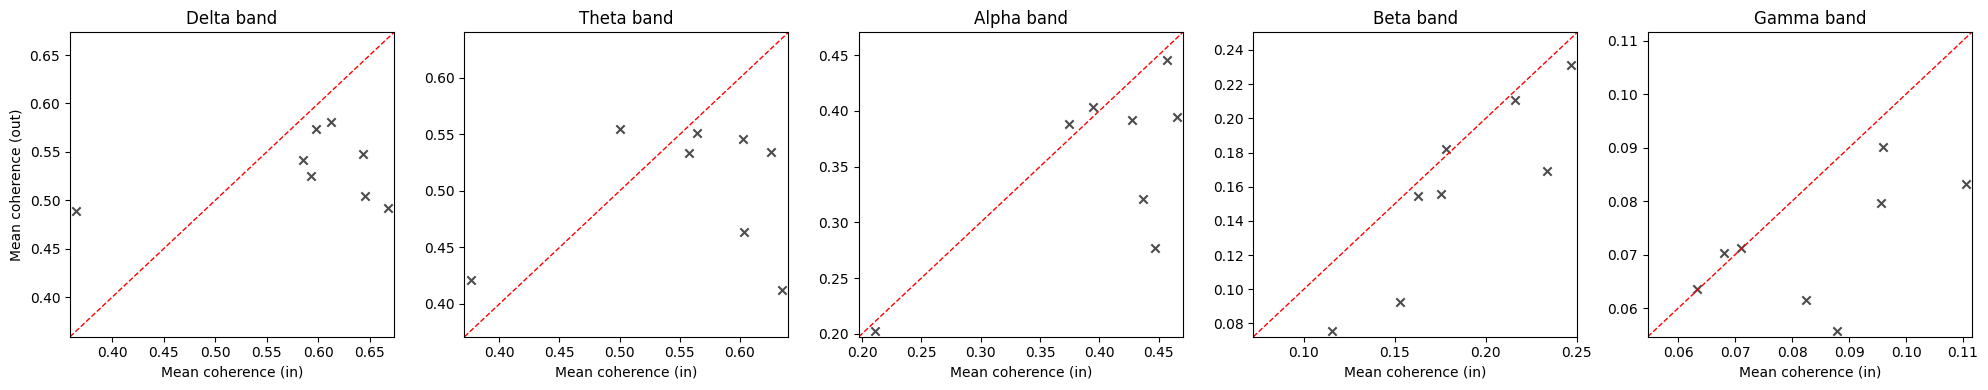

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute per‐band “in” & “out” lists (assuming coherence_results already filled)
coherence_in  = {band: [] for band in bands}
coherence_out = {band: [] for band in bands}

for fn in file_numbers:
    for band in bands:
        # “In” = attend-left→left_attleft & attend-right→right_attright
        in_vals = [
            coherence_results[fn][band]['left_attleft'],
            coherence_results[fn][band]['right_attright']
        ]
        coherence_in[band].append(np.mean(in_vals))

        # “Out” = attend-left→right_attleft & attend-right→left_attright
        out_vals = [
            coherence_results[fn][band]['right_attleft'],
            coherence_results[fn][band]['left_attright']
        ]
        coherence_out[band].append(np.mean(out_vals))

# 2) Compute axis limits per band
lims = {}
for band in bands:
    allv = coherence_in[band] + coherence_out[band]
    mn, mx = min(allv), max(allv)
    pad = (mx - mn) * 0.02
    lims[band] = (mn - pad, mx + pad)

# 3) Plot
fig, axs = plt.subplots(1, len(bands), figsize=(4*len(bands), 4), tight_layout=True)
for ax, band in zip(axs, bands):
    x = coherence_in[band]
    y = coherence_out[band]
    mn, mx = lims[band]

    ax.scatter(x, y, marker='x', color='k', alpha=0.7)
    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=1)      # unity line in data coords
    ax.set_xlim(mn, mx)
    ax.set_ylim(mn, mx)

    ax.set_xlabel('Mean coherence (in)')
    if band == bands[0]:
        ax.set_ylabel('Mean coherence (out)')
    ax.set_title(f'{band.capitalize()} band')

plt.show()


In [38]:
print(coherence_in, coherence_out)

{'delta': [np.float64(0.6673778552156302), np.float64(0.6448648038035816), np.float64(0.5977781165666217), np.float64(0.5926197223014054), np.float64(0.6123574383027514), np.float64(0.3651782794395037), np.float64(0.5848638030524005), np.float64(0.6435850692256351)], 'theta': [np.float64(0.6033967133289011), np.float64(0.6351771667945202), np.float64(0.6023751574209515), np.float64(0.6258740903181771), np.float64(0.5005021352368335), np.float64(0.37622295859962396), np.float64(0.5646852537239209), np.float64(0.5573480542933474)], 'alpha': [np.float64(0.44674483319259606), np.float64(0.43635989619173365), np.float64(0.4651076091753077), np.float64(0.45697414617259613), np.float64(0.3743506462183017), np.float64(0.21134810972956045), np.float64(0.42783868412011383), np.float64(0.3942545162576843)], 'beta': [np.float64(0.1780501625873259), np.float64(0.1527800284910107), np.float64(0.2335148158434661), np.float64(0.2468633242108572), np.float64(0.1625011306097818), np.float64(0.1156924986